In [1]:
# Google Driveをマウント
from google.colab import userdata, drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Fitbit

/content/drive/MyDrive/Fitbit


In [8]:
import requests
import json

# 設定ファイルのパス
CONFIG_FILE = "token.json"

def load_config():
    """設定ファイルを読み込む"""
    try:
        with open(CONFIG_FILE, "r", encoding="utf-8") as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"設定ファイル {CONFIG_FILE} が見つかりません。")
        exit(1)

def save_config(config):
    """設定ファイルを保存する"""
    with open(CONFIG_FILE, "w", encoding="utf-8") as f:
        json.dump(config, f, indent=2)

def create_auth_header(access_token):
    """認証用のヘッダを作成する"""
    return {"Authorization": "Bearer " + access_token}

def refresh_access_token(config):
    """アクセストークンを更新する"""
    url = "https://api.fitbit.com/oauth2/token"
    params = {
        "grant_type": "refresh_token",
        "refresh_token": config["refresh_token"],
        "client_id": config["client_id"],
    }

    response = requests.post(url, data=params)
    data = response.json()

    if "errors" in data:
        print(f"アクセストークンの更新に失敗しました: {data['errors'][0]['message']}")
        return False

    config["access_token"] = data["access_token"]
    config["refresh_token"] = data["refresh_token"]
    save_config(config)
    return True

def is_token_expired(response_data):
    """アクセストークンの有効期限が切れているかチェックする"""
    if "errors" in response_data:
        for error in response_data["errors"]:
            if error.get("errorType") == "expired_token":
                print("アクセストークンの有効期限が切れています。")
                return True
    return False

def make_api_request(url, headers):
    """APIリクエストを実行する"""
    response = requests.get(url, headers=headers)
    data = response.json()

    if is_token_expired(data):
        config = load_config()
        if refresh_access_token(config):
            headers = create_auth_header(config["access_token"])
            response = requests.get(url, headers=headers)
        else:
            print("アクセストークンの更新に失敗したため、リクエストを中止します。")
            exit(1)

    return response

def get_heart_rate(date="today", period="1d"):
    """心拍数データを取得する"""
    url = f"https://api.fitbit.com/1/user/-/activities/heart/date/{date}/{period}.json"
    config = load_config()
    headers = create_auth_header(config["access_token"])
    return make_api_request(url, headers)

if __name__ == "__main__":
    response = get_heart_rate(date="2024-03-09")
    data = response.json()
    # print(json.dumps(data, indent=2))
    print(data["activities-heart-intraday"]["dataset"][0])

{'time': '00:00:00', 'value': 65}


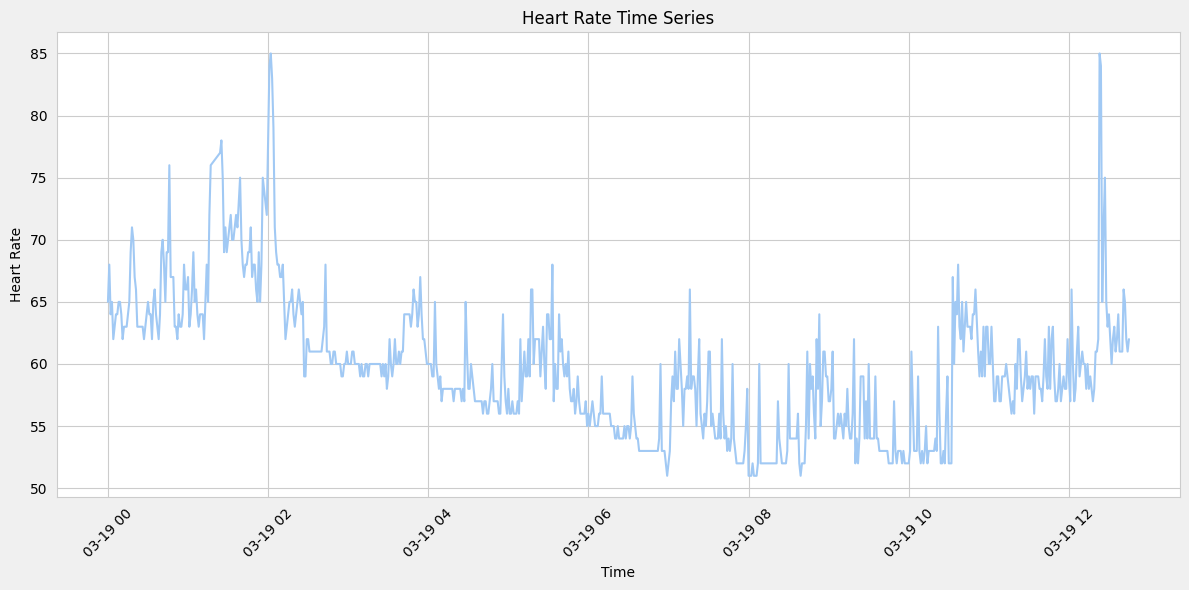

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# データをDataFrameに変換
heart_data = data["activities-heart-intraday"]["dataset"]
df = pd.DataFrame(heart_data)

# 'time'列をdatetime型に変換
df['time'] = pd.to_datetime(df['time'])

# グラフのスタイルを設定
sns.set_style("whitegrid")

# パステルカラーのカラーパレットを作成
pastel_colors = sns.color_palette("pastel")

# グラフを描画
plt.figure(figsize=(12, 6))
sns.lineplot(x='time', y='value', data=df, color=pastel_colors[0])

# グラフのタイトルと軸ラベルを設定
plt.title("Heart Rate Time Series", color='black')
plt.xlabel("Time", color='black')
plt.ylabel("Heart Rate", color='black')

# x軸の目盛りを設定
plt.xticks(rotation=45, color='black')
plt.yticks(color='black')

# グラフの背景色を設定
fig = plt.gcf()
fig.set_facecolor('#F0F0F0')

# グラフを表示
plt.tight_layout()
plt.show()